<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated by [Sergey Oreshkov](https://www.linkedin.com/in/sergeoreshkov/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #8 (demo)

## <center> Implementation of online regressor

Here we'll implement a regressor trained with stochastic gradient descent (SGD). Fill in the missing code. If you do evething right, you'll pass a simple embedded test.

## <center>Linear regression and Stochastic Gradient Descent

tensor([0.1626], requires_grad=True)


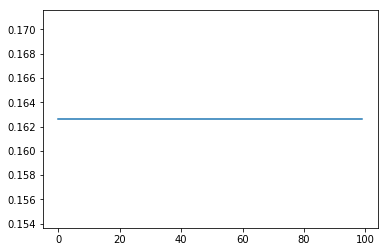

In [1]:
import torch
from matplotlib import pyplot as plt

w = torch.tensor([1.], requires_grad=True)
alpha = 0.009
optimizer = torch.optim.SGD([w], lr=alpha)
w_s = []
for _ in range(100):

    function = w**2
    function.backward()
    optimizer.step()
    w_s.append(w.data)
    optimizer.zero_grad()

print(w)

plt.plot(range(100), w_s)

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Implement class `SGDRegressor`. Specification:
- class is inherited from `sklearn.base.BaseEstimator`
- constructor takes parameters `eta` – gradient step ($10^{-3}$ by default) and `n_epochs` – dataset pass count (3 by default)
- constructor also creates `mse_` and `weights_` lists in order to track mean squared error and weight vector during gradient descent iterations
- Class has `fit` and `predict` methods
- The `fit` method takes matrix `X` and vector `y` (`numpy.array` objects) as parameters, appends column of ones to  `X` on the left side, initializes weight vector `w` with **zeros** and then makes `n_epochs` iterations of weight updates (you may refer to this [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-8-vowpal-wabbit-fast-learning-with-gigabytes-of-data-60f750086237) for details), and for every iteration logs mean squared error and weight vector `w` in corresponding lists we created in the constructor. 
- Additionally the `fit` method will create `w_` variable to store weights which produce minimal mean squared error
- The `fit` method returns current instance of the `SGDRegressor` class, i.e. `self`
- The `predict` method takes `X` matrix, adds column of ones to the left side and returns prediction vector, using weight vector `w_`, created by the `fit` method.

In [3]:
class SGDRegressor(BaseEstimator):
    
    def __init__(self, eta=0.001, n_epochs=3):

        super().__init__() 
        
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for iteration in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):
                
                w_updated = w.copy()
                
                w_updated[0] += self.eta * (y[i] - w.dot(X[i, :]))
                
                for j in range(1, X.shape[1]):                    
                    w_updated[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j] 
                    
                w = w_updated.copy()
                
                self.weights_.append(w)
                
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        best_mse = np.argmin(self.mse_)
        self.w_ = self.weights_[best_mse]
                
        return self
                  
    def predict(self, X):
        
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        return X.dot(self.w_)

Let's test out the algorithm on height/weight data. We will predict heights (in inches) based on weights (in lbs).

In [4]:
data_demo = pd.read_csv('../input/weights_heights.csv')

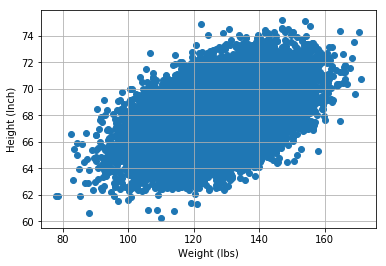

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (Inch)')
plt.grid();

In [6]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Perform train/test split and scale data.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

Train created `SGDRegressor` with `(X_train_scaled, y_train)` data. Leave default parameter values for now.

In [9]:
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:22<00:00,  7.37s/it]


SGDRegressor(eta=0.001, n_epochs=3)

Draw a chart with training process  – dependency of mean squared error from the i-th SGD iteration number.

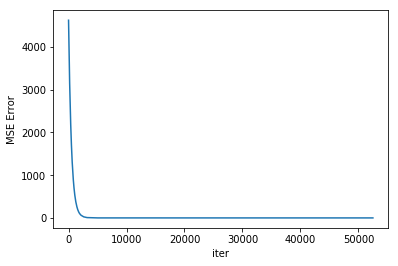

In [10]:
plt.plot(range(len(sgd.mse_)), sgd.mse_)
plt.xlabel('iter')
plt.ylabel('MSE Error')
plt.show()

Print the minimal value of mean squared error and the best weights vector.

In [11]:
np.min(sgd.mse_), sgd.w_

(2.7151352406643627, array([67.9898497 ,  0.94447605]))

Draw chart of model weights ($w_0$ and $w_1$) behavior during training.

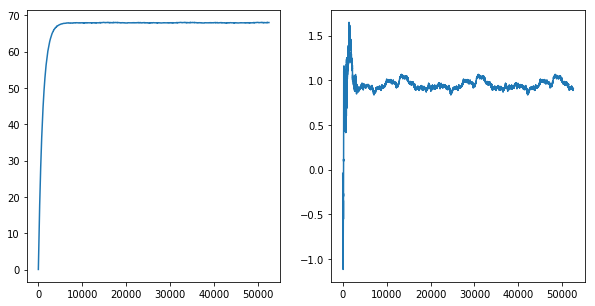

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(sgd.weights_)), 
         [w[0] for w in sgd.weights_])

plt.subplot(1, 2, 2)
plt.plot(range(len(sgd.weights_)), 
         [w[1] for w in sgd.weights_])

Make a prediction for hold-out  set `(X_valid_scaled, y_valid)` and check MSE value.

In [13]:
sgd_holdout_mse = mean_squared_error(y_valid, sgd.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Do the same thing for `LinearRegression` class from `sklearn.linear_model`. Evaluate MSE for hold-out set.

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

linreg_holdout_mse = mean_squared_error(y_valid, lr.predict(X_valid_scaled))
linreg_holdout_mse

2.670830767667635

In [15]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print('Correct!')
except AssertionError:
    print("Something's not good.\n Linreg's holdout MSE: {}"
          "\n SGD's holdout MSE: {}".format(linreg_holdout_mse, 
                                            sgd_holdout_mse))

Correct!
